# TP2 Visión por Computadora 1 CEIA FIUBA
Profesor: Ing. Maxim Dorogov
Autores:
        Alvarez, Jorge Adrián
        Peñaranda Peralta, Daniel Eduardo

**Objetivo:**
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Extracción de los cuadros del video `focus_video.mov` a un array de imágenes

Cuadros cargados: 171 - arreglo con forma (171, 360, 640)


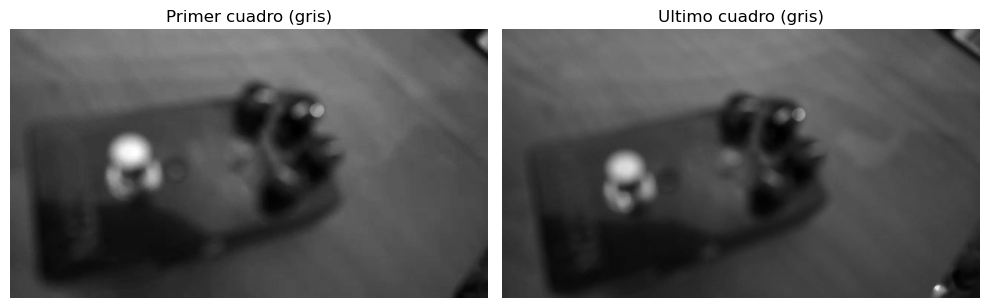

In [5]:
video_path = "focus_video.mov"
cap = cv2.VideoCapture(video_path)
frames_gray = []
if not cap.isOpened():
    raise IOError(f"No se pudo abrir el video en {video_path}")

while True:
    ret, frame = cap.read()
    if not ret:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    frames_gray.append(gray)

cap.release()

frames_gray = np.array(frames_gray)
num_frames = frames_gray.shape[0]
print(f"Cuadros cargados: {num_frames} - arreglo con forma {frames_gray.shape}")

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(frames_gray[0], cmap="gray")
axes[0].set_title("Primer cuadro (gris)")
axes[0].axis("off")

axes[1].imshow(frames_gray[-1], cmap="gray")
axes[1].set_title("Ultimo cuadro (gris)")
axes[1].axis("off")

plt.tight_layout()
plt.show()

# 1. Medida de desenfoque en el dominio de la frecuencia
Clase calidad de enfoque con métodos:
- `_fm_fram` realiza en el cálculo de `coeficiente calidad de enfoque` (FM Image Quality measure, en el trabajo) para una imagen de $ N \times M $, según del algoritmo propuesto por Kanjar De and V. Masilamani en el trabajo *Image Sharpness Measure for Blurred Images in Frequency Domain*   
- `calidad` recibe un array de $ r $ ROIs tomados de $ t $  de tamaño $ N \times M $: $(r,t,N,M)$. También acepta arrays de $t$ cuadros de tamaño $ N \times M $: $(t,N,M)$ y devuelve un array de $r$ filas con $t$ `coeficientes de calidad de enfoque`: $(r,t)$ en el primer caso y $t$ `coeficientes de calidad de enfoque` ($t$,) en el segundo caso.
- `grafico` devuelve el `coeficiente de calidad de enfoque` **máximo** y el cuadro en el que se alcanza y el gráfico de los coeficientes por cuadro. 

In [47]:
class CalidadEnfoque:
    """Calcula FM cuadro a cuadro y grafica los resultados."""

    def __init__(self, threshold: float = 1000.0):
        self.threshold = threshold

    def _fm_frame(self, image: np.ndarray) -> float:
        float_img = np.float32(image)
        fourier = cv2.dft(float_img, flags=cv2.DFT_COMPLEX_OUTPUT)
        fourier_centered = np.fft.fftshift(fourier)
        magnitude = cv2.magnitude(fourier_centered[:, :, 0], fourier_centered[:, :, 1])
        max_val = magnitude.max()
        if max_val == 0:
            return 0.0

        threshold = max_val / self.threshold
        th = np.count_nonzero(magnitude > threshold)
        rows, cols = image.shape
        fm = th / (rows * cols)
        return fm

    def calidad(self, frames: np.ndarray) -> np.ndarray:
        """Devuelve el FM para cada cuadro (o filas de cuadros)."""
        arr = np.array(frames)
        if arr.ndim == 3:
            sequences = arr[None, ...]
            squeeze_output = True
        elif arr.ndim == 4:
            sequences = arr
            squeeze_output = False
        else:
            raise ValueError(
                "Esperaba un array de forma (cuadros, alto, ancho) o (filas, cuadros, alto, ancho)."
            )

        fm_rows = []
        for seq in sequences:
            fm_seq = np.array([self._fm_frame(frame) for frame in seq])
            fm_rows.append(fm_seq)

        fm_array = np.stack(fm_rows, axis=0)
        return fm_array[0] if squeeze_output else np.mean(fm_array,axis=0)#Se promedian los coeficientes obtenidos para cada ROI

    def grafico(self, fm_values: np.ndarray):
        """Grafica FM vs. numero de cuadro y devuelve maximos y posiciones."""
        fm_arr = np.array(fm_values, dtype=float)
        if fm_arr.ndim == 1:
            fm_arr = fm_arr[None, :]
            squeeze_output = True
        elif fm_arr.ndim == 2: #Al tomar promedio del los ROI no se obtendrán fm_arr de dimensión 2 
            squeeze_output = False
        else:
            raise ValueError("Esperaba un array 1D (cuadros) o 2D (filas, cuadros) con medidas de enfoque.")

        plt.figure(figsize=(10, 6))
        maxima = []
        frame_idx = np.arange(fm_arr.shape[1])

        for idx, row in enumerate(fm_arr):
            plt.scatter(frame_idx, row)
            max_pos = int(np.argmax(row))
            max_val = float(row[max_pos])
            maxima.append([max_val, max_pos])

        plt.xlabel("Numero de cuadro")
        plt.ylabel("Medida de enfoque (FM)")
        plt.title("Calidad de enfoque por cuadro")
       
        if fm_arr.shape[0] > 1:
            plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        
        if squeeze_output:
            output=maxima[0]
            plt.plot(output[1], output[0], 'ro')
        else:
            m=np.asarray(maxima)
            idx=np.argmax(m[:,0])
            output=[int(idx+1)]+maxima[idx] 
            plt.plot(output[2], output[1], 'ro')
        plt.show()
        return output


Se calcula el índice de enfoque máximo sobre el total de la imagen en cada cuadro y se muestra cual es el cuadro para que este índice es máximo

Forma del array FM: (171,)


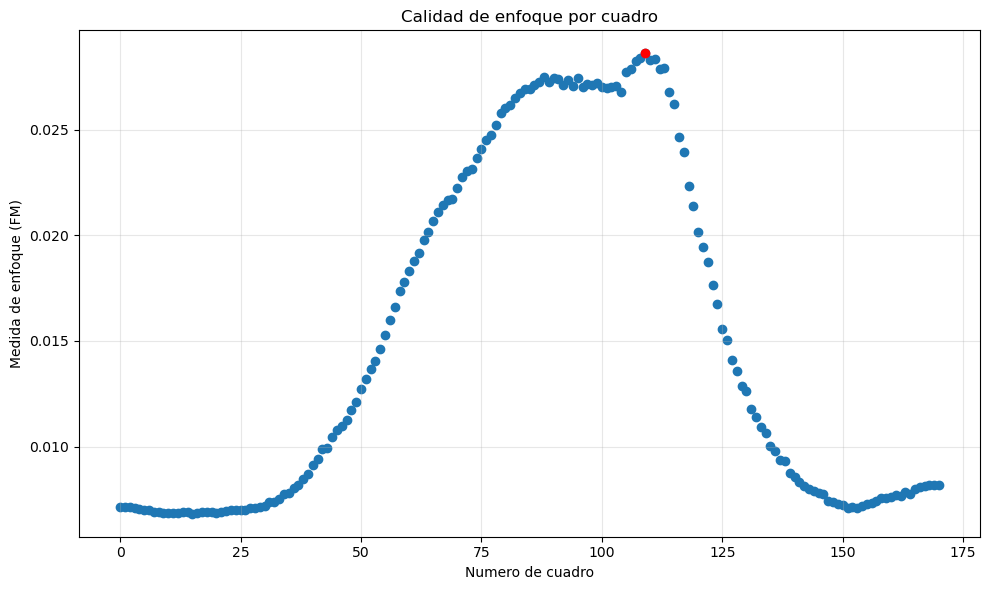

Máximo y cuadro correspondiente: [0.028624131944444443, 109]


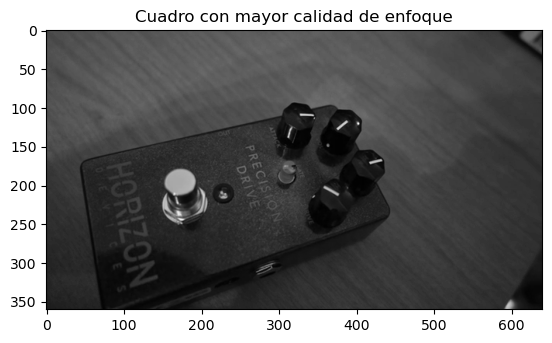

In [48]:

analyzer = CalidadEnfoque()
fm_por_cuadro = analyzer.calidad(frames_gray)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print("Máximo y cuadro correspondiente:", maximo)
plt.imshow(frames_gray[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque")
plt.show()

Se define la función `extraer_reticula_central` que toma un cuadro y devuelve el recorte de una reticula central (ROI central) de un dado porcentaje de la imagen. Devuelve además las coordenadas de la ROI central.  

In [24]:
def extraer_reticula_central(frames: np.ndarray, porcentaje: float = 0.07):
    """Extrae una reticula central de cada cuadro.

    Devuelve las coordenadas (x1, y1, x2, y2) y el array de recortes.
    """
    arr = np.array(frames)
    if arr.ndim != 3:
        raise ValueError("Esperaba un array de forma (cuadros, alto, ancho) en escala de grises.")

    h, w = arr.shape[1:]
    ancho = max(1, int(w * porcentaje))
    alto = max(1, int(h * porcentaje))
    x1 = (w - ancho) // 2
    y1 = (h - alto) // 2
    x2 = x1 + ancho
    y2 = y1 + alto

    recortes = arr[:, y1:y2, x1:x2]
    return (x1, y1, x2, y2), recortes


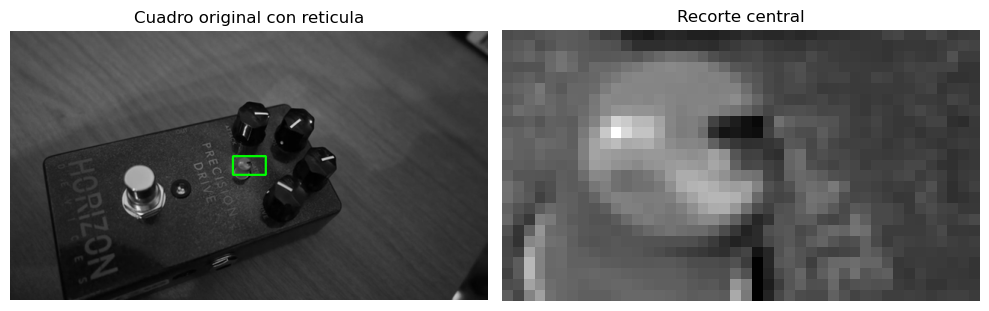

In [10]:
# Recorte central y visualización, Ejemplo.
coords, recortes = extraer_reticula_central(frames_gray)
x1, y1, x2, y2 = coords
frame_idx =109

frame_bgr = cv2.cvtColor(frames_gray[frame_idx], cv2.COLOR_GRAY2BGR)
cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].imshow(cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB))
axes[0].set_title("Cuadro original con reticula")
axes[0].axis("off")

axes[1].imshow(recortes[frame_idx], cmap="gray")
axes[1].set_title("Recorte central")
axes[1].axis("off")

plt.tight_layout()
plt.show()



Se calcula la calidad de enfoque sobre los recortes obtenidos de cada cuadro, se grafica por cuadro y se muestra el cuadro donde el `coeficiente de calidad de enfoque` fue máximo.

Forma del array FM (reticula): (171,)


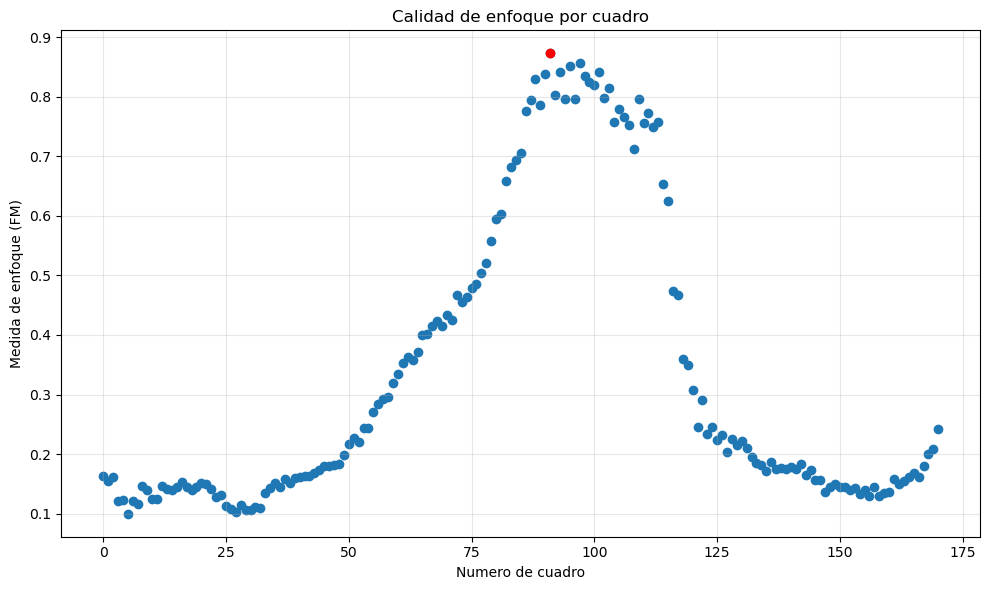

Maximo y cuadro (reticula): [0.8727272727272727, 91]


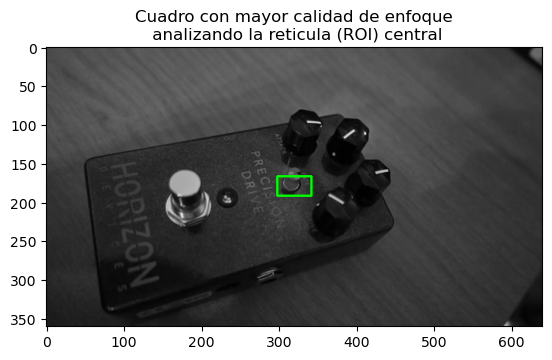

In [49]:
# Calidad de enfoque sobre la reticula extraida
analyzer_recorte = CalidadEnfoque()
fm_reticula = analyzer_recorte.calidad(recortes)
print(f"Forma del array FM (reticula): {fm_reticula.shape}")
maximo_reticula = analyzer_recorte.grafico(fm_reticula)
print("Maximo y cuadro (reticula):", maximo_reticula)

frame_bgr = cv2.cvtColor(frames_gray[maximo_reticula[1]], cv2.COLOR_GRAY2BGR)
cv2.rectangle(frame_bgr, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(frame_bgr , cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque\n analizando la reticula (ROI) central")
plt.show()

In [38]:
def calculo_matriz_enfoque(h: int, w: int, rows: int=4, cols:int=6, porcentaje: float=0.5):
    """
    Calcula las coordenadas (x0, y0, x1, y1) de una grilla de retículas
    centrada en la imagen, equiespaciadas.
    Devuelve:
      - boxes: lista de tuplas (x0, y0, x1, y1)
      - patch_size: lado (en píxeles) de cada retícula
      - coverage: fracción de área de imagen cubierta por las retículas
    """
    # rectángulo proporcional a la imagen donde se ubica la matriz de enfoque
    ancho = max(1, int(w * porcentaje))
    alto = max(1, int(h * porcentaje))
    x1 = (w - ancho) // 2 # coordenada de inicio para centrar la matriz
    y1 = (h - alto) // 2
    x2 = x1 + ancho
    y2 = y1 + alto

    # lado de la retícula cuadrada: para que quepan (2*cols - 1) bloques horizontales
    # toma el menor de los lados
    # cuadrado, espacio, cuadrado, espacio, ... (cols cuadrados + cols-1 espacios)
    lado = int(
        min(
            (ancho) / (2 * cols - 1),
            (alto)/ (2 * rows - 1),
        )
    )
    boxes = []
    for r in range(rows):
        for c in range(cols):
            x0 = x1 + (2 * c) * lado
            y0 = y1 + (2 * r) * lado
            x_1 = x0 + lado
            y_1 = y0 + lado
            boxes.append((x0, y0, x_1, y_1))

    # porcentaje de área cubierta
    coverage = (len(boxes) * lado * lado) / (h * w)

    return boxes, lado, coverage

In [50]:
def dibuja_matriz_sobre_frame(frame: np.array, boxes: list, color: tuple=(0, 255, 0), thickness: int=2)-> np.array:
    """
    Dibuja rectángulos en verde sobre una copia de 'frame'.
    """
    img_vis = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    
    for idx, (x0, y0, x1, y1) in enumerate(boxes):
        cv2.rectangle(img_vis, (x0, y0), (x1, y1), color, thickness)
        cv2.putText(img_vis,f'{idx+1}', (x0,y0-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
        
    return img_vis

<function matplotlib.pyplot.show(close=None, block=None)>

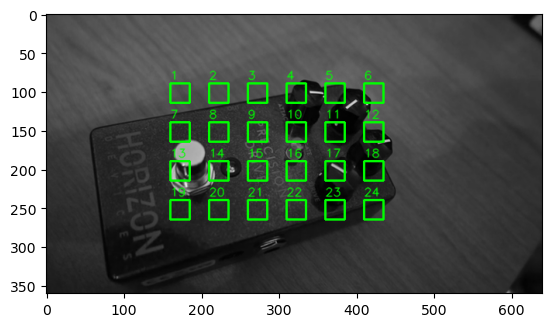

In [51]:
h, w = frames_gray.shape[1:]
boxes, lado, cobertura=calculo_matriz_enfoque(h,w) 
img=dibuja_matriz_sobre_frame(frames_gray[100],boxes)
plt.imshow(img)
plt.show


In [54]:
def extraer_regiones_de_frames(frames:np.array, rows:int=3, cols:int=6):
    """
    frames: np.ndarray de forma (t, H, W)
    Devuelve:
      - regiones: np.ndarray de forma (nro_roi= rows x cols, t, rh, rw),
      - boxes: lista de (x0, y0, x1, y1) compartida por todos los frames
      -lado,coverage: como en calculo_matriz_enfoque
    """
    frames = np.asarray(frames)
    fr, h, w = frames.shape

    boxes,lado,coverage = calculo_matriz_enfoque(h, w, rows, cols)
    
    num_boxes = len(boxes)
    regiones = [[] for _ in range(num_boxes)]   # una lista por cada retícula

    for t in range(fr):
        img = frames[t]
        for i, (x0, y0, x1, y1) in enumerate(boxes):
            roi = img[y0:y1, x0:x1].copy()
            regiones[i].append(roi)

    regiones = np.array(regiones)  # (nro_roi, fr, rh, rw)
    return regiones, boxes,lado,coverage

Forma del array FM: (171,)


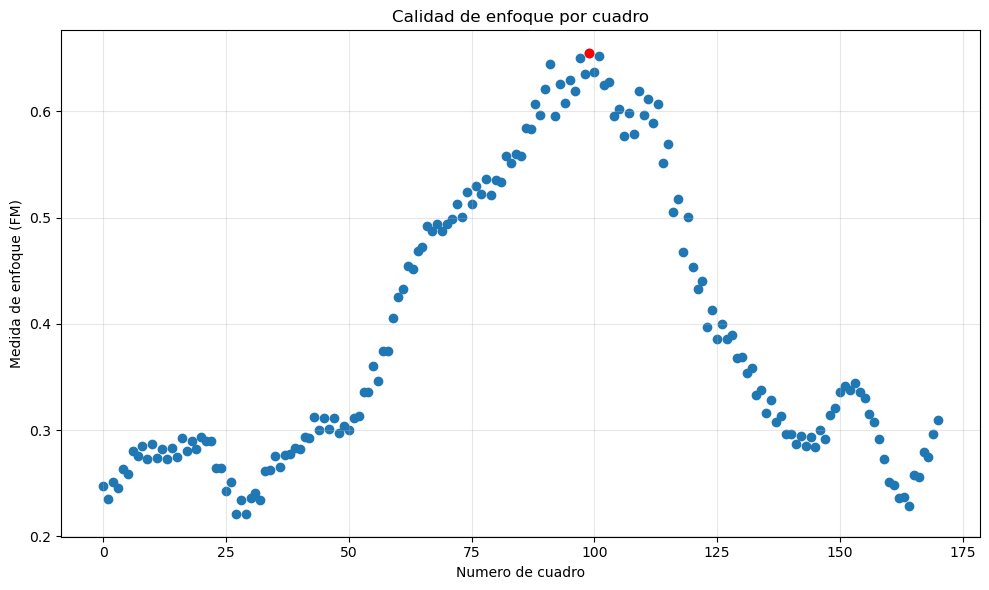

Máximo coeficiente de enfoque promedio:0.6545118245474963 y cuadro correspondiente: 99


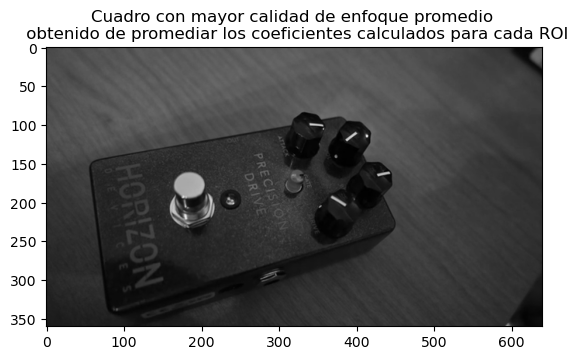

In [55]:
regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)

analyzer = CalidadEnfoque()
fm_por_cuadro = analyzer.calidad(regiones)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()

## 2. Utilización de la como factor de calidad de enfoque **Variance of Laplacian**

Del paper: Said P. et al., *Analysis of focus measure operators in shapefrom focus*

Pertenece a la familia Laplaciana (LAP4).

Los operadores Laplacianos fueron de los mejores en condiciones normales y bastante consistentes.

La varianza de la respuesta Laplaciana mide cuánto “cambia” la segunda derivada → escenas enfocadas tienen muchos bordes/detalles → alta varianza; escenas desenfocadas → Laplaciano más suave → baja varianza.

Es barato computacionalmente y se implementa directo con cv2.Laplacian + np.var.

In [56]:
class CalidadEnfoqueLaplaciano(CalidadEnfoque):
    """
    Calcula la medida de enfoque usando 'Variance of Laplacian' (LAP4).
    FM = var( L * I )
    donde L es el operador Laplaciano aplicado a la imagen I.
    """

    def __init__(self, ksize: int = 3):
        """ksize: tamaño del kernel del Laplaciano (3, 5, ...).
        """
        super().__init__()  # Reutiliza threshold aunque acá no se usa
        self.ksize = ksize

    def _fm_frame(self, image: np.ndarray) -> float:
        # Redundante pero para estar seguro de trabajar en escala de grises
        if image.ndim == 3:
             gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        else:
            gray = image

        gray = np.float32(gray)

        # Laplaciano (segunda derivada espacial)
        lap = cv2.Laplacian(gray, ddepth=cv2.CV_32F, ksize=self.ksize)

        # Varianza de la respuesta Laplaciana
        fm = float(lap.var())

        
        return fm

Forma del array FM: (171,)


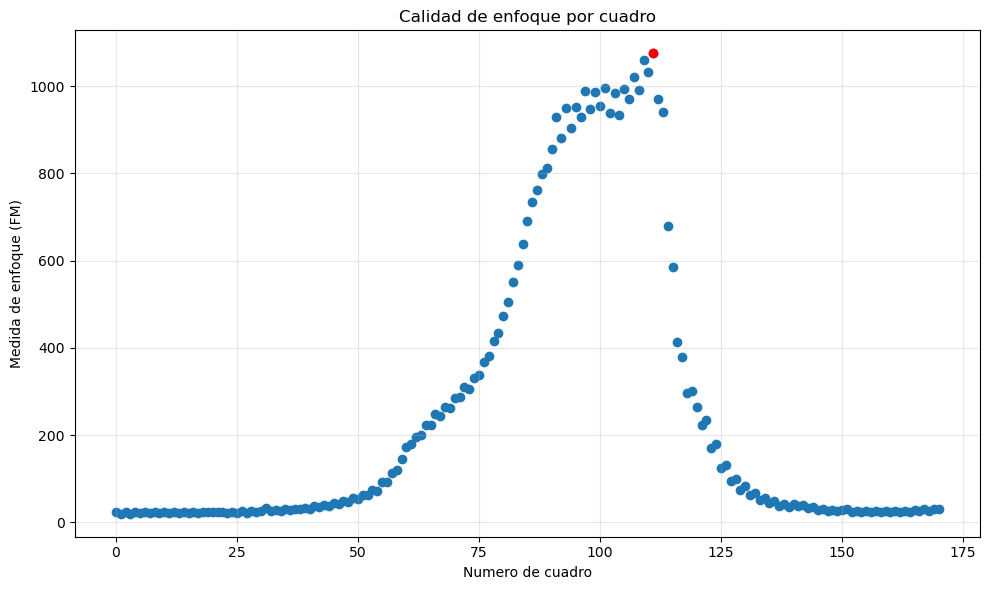

Maximo y cuadro correspondiente: [1074.9931640625, 111]


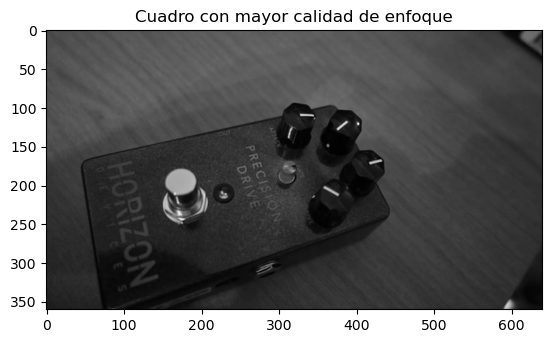

In [57]:
analyzer = CalidadEnfoqueLaplaciano()
fm_por_cuadro = analyzer.calidad(frames_gray)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print("Maximo y cuadro correspondiente:", maximo)
plt.imshow(frames_gray[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque")
plt.show()

Forma del array FM (reticula): (171,)


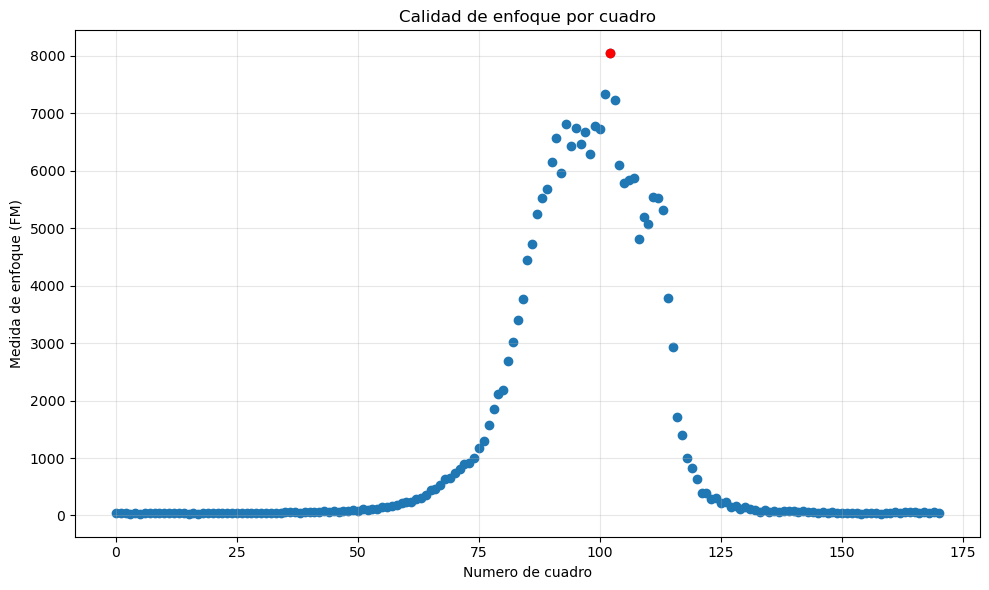

Maximo y cuadro (reticula): [8040.30712890625, 102]


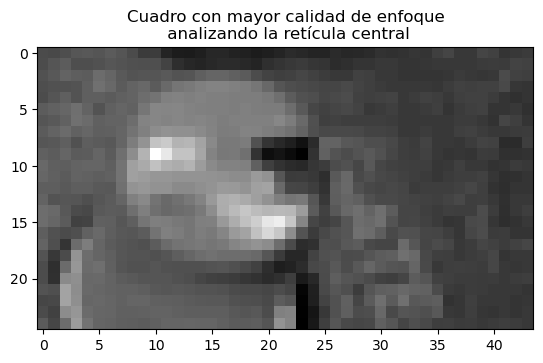

In [58]:
analyzer_recorte = CalidadEnfoqueLaplaciano() 
fm_reticula = analyzer_recorte.calidad(recortes)
print(f"Forma del array FM (reticula): {fm_reticula.shape}")
maximo_reticula = analyzer_recorte.grafico(fm_reticula)
print("Maximo y cuadro (reticula):", maximo_reticula)

plt.imshow(recortes[maximo[1]], cmap="gray")
plt.title("Cuadro con mayor calidad de enfoque\n analizando la retícula central")
plt.show()

Forma del array FM: (171,)


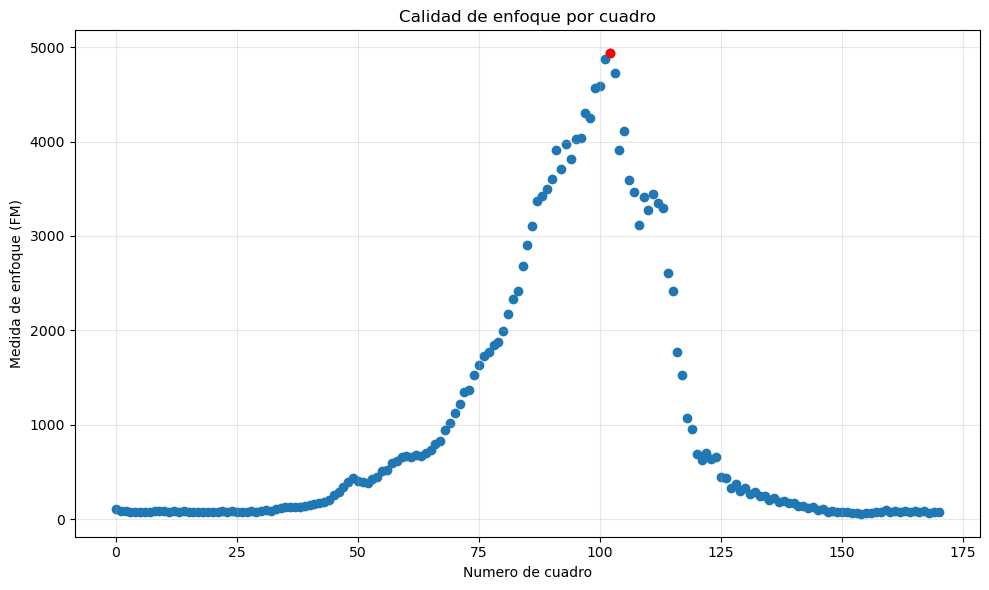

Máximo coeficiente de enfoque promedio:4933.932381735907 y cuadro correspondiente: 102


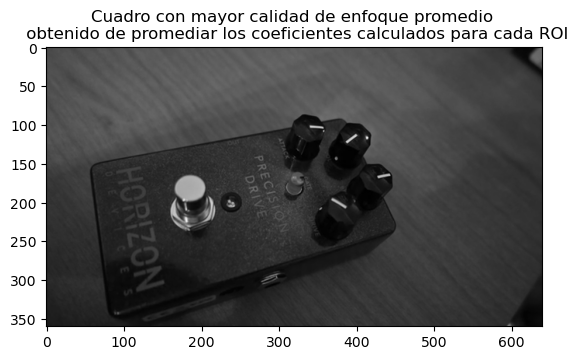

In [59]:
regiones, boxes,lado,coverage=extraer_regiones_de_frames(frames_gray)

analyzer = CalidadEnfoqueLaplaciano() 
fm_por_cuadro = analyzer.calidad(regiones)
print(f"Forma del array FM: {fm_por_cuadro.shape}")

maximo = analyzer.grafico(fm_por_cuadro)
print(f'Máximo coeficiente de enfoque promedio:{maximo[0]} y cuadro correspondiente: {maximo[1]}')

img_vis = cv2.cvtColor(frames_gray[maximo[1],...], cv2.COLOR_GRAY2BGR)
plt.imshow(img_vis)
plt.title('Cuadro con mayor calidad de enfoque promedio \n obtenido de promediar los coeficientes calculados para cada ROI')
plt.show()